# EDA
Here I will explore relationships between the different features in my data.

**imports**

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import os
import sys

sys.path.append("./util_")
import prepare_
import explore_

# set a default them for all my visuals
sns.set_theme(style="whitegrid")

**get data**

In [23]:
# load vehicle data
vehicle = prepare_.get_vehicle_data_no_dummies()

Original dataframe size: (2004974, 30)
New dataframe size: (2004974, 24)


**split data**

In [24]:
train, validate, test = prepare_.split_data_(vehicle, test_size=0.2, stratify_col="fatality", random_state=95 )
(train.shape, validate.shape, test.shape)

((1202984, 24), (400995, 24), (400995, 24))

In [25]:
train.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,fatality
728700,2018-01-13,2023-07-19 17:05:00,QUEENS,11422,40.656616,-73.744965,UNKNOWN,UNKNOWN,147-26 BROOKVILLE BOULEVARD,0,...,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,SEDAN,SEDAN,UNKNOWN,UNKNOWN,UNKNOWN,0
470214,2019-02-27,2023-07-19 17:50:00,QUEENS,11417,40.672783,-73.843250,UNKNOWN,UNKNOWN,135-45 CROSS BAY BOULEVARD,0,...,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,STATION_WAGON,STATION_WAGON,UNKNOWN,UNKNOWN,UNKNOWN,0
1356648,2015-03-31,2023-07-19 03:30:00,BROOKLYN,11211,40.708426,-73.957904,BROADWAY,MARCY AVENUE,UNKNOWN,0,...,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,LIVERY_VEHICLE,PASSENGER_VEHICLE,UNKNOWN,UNKNOWN,UNKNOWN,0
1903801,2012-08-08,2023-07-19 18:30:00,MANHATTAN,10007,40.713135,-74.004058,CENTRE STREET,CHAMBERS STREET,UNKNOWN,0,...,Driver Fatigue and Inattention,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,PICKUP_TRUCK,PASSENGER_VEHICLE,UNKNOWN,UNKNOWN,UNKNOWN,0
1731955,2013-06-13,2023-07-19 12:10:00,BROOKLYN,11212,40.671924,-73.904516,GLENMORE AVENUE,POWELL STREET,UNKNOWN,0,...,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,PASSENGER_VEHICLE,PASSENGER_VEHICLE,UNKNOWN,UNKNOWN,UNKNOWN,0


In [26]:
# look at the number of unique categories
train.nunique()

crash_date                         4014
crash_time                         1440
borough                               6
zip_code                            233
latitude                         111523
longitude                         87266
on_street_name                    14981
cross_street_name                 17171
off_street_name                  141081
number_of_persons_injured            29
number_of_pedestrians_injured        13
number_of_cyclist_injured             4
number_of_motorist_injured           28
contributing_factor_vehicle_1        16
contributing_factor_vehicle_2        16
contributing_factor_vehicle_3        15
contributing_factor_vehicle_4        13
contributing_factor_vehicle_5        12
vehicle_type_code_1                  50
vehicle_type_code_2                  50
vehicle_type_code_3                  46
vehicle_type_code_4                  36
vehicle_type_code_5                  28
fatality                              2
dtype: int64

## Univariate Stats

In [18]:
# find only columns with low count of categories
low_category_cols = train.nunique()[train.nunique() < 50].index

# low_category_cols = low_category_cols[low_category_cols != "borough"]
# low_category_cols = low_category_cols[low_category_cols != "propertycountylandusecode"]
low_category_cols

Index(['borough', 'number_of_persons_injured', 'number_of_pedestrians_injured',
       'number_of_cyclist_injured', 'number_of_motorist_injured',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'contributing_factor_vehicle_3', 'contributing_factor_vehicle_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_3',
       'vehicle_type_code_4', 'vehicle_type_code_5', 'fatality'],
      dtype='object')

**Univarate for categorical variables**

In [19]:
def plot_categorical_and_continuous_vars():
    # plot all the low category columns to see the distributions
    for col in low_category_cols[:-1]:
        print(col.upper())
        print("count of unique:",train[col].nunique())
        print(train[col].value_counts().sort_values())

        # plot
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17,4))
        sns.countplot(data= train, x=col, ax=ax)
#         sns.boxplot(data= train, x=col, ax=ax[1])
#         sns.violinplot(data= train, x=col, ax=ax[2])
        plt.tight_layout()

        # save visual to file path
        explore_.save_visuals(fig=fig, viz_name=col, folder_name= 1)

        plt.show()

BOROUGH
count of unique: 6
STATEN ISLAND     34721
BRONX            122083
MANHATTAN        186655
QUEENS           222141
BROOKLYN         262939
UNKNOWN          374445
Name: borough, dtype: int64


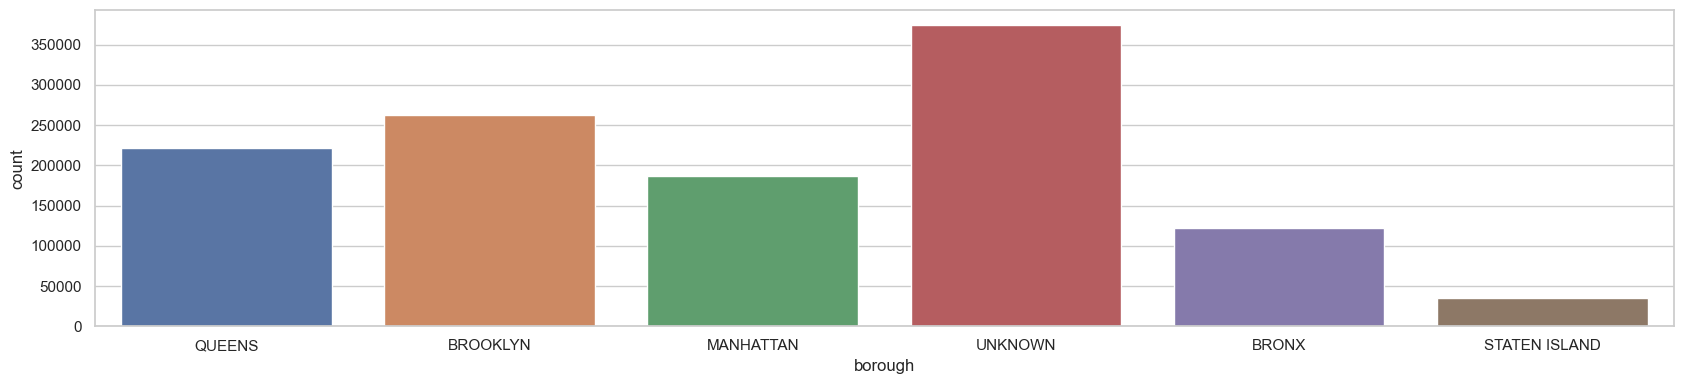

NUMBER_OF_PERSONS_INJURED
count of unique: 29
22         1
21         1
23         1
34         1
40         1
31         1
43         1
19         1
24         2
20         2
17         4
18         4
15         5
14         7
16         8
13        15
12        18
11        27
10        49
9         73
8        142
7        323
6        791
5       1851
4       4717
3      12766
2      38809
1     206992
0     936371
Name: number_of_persons_injured, dtype: int64


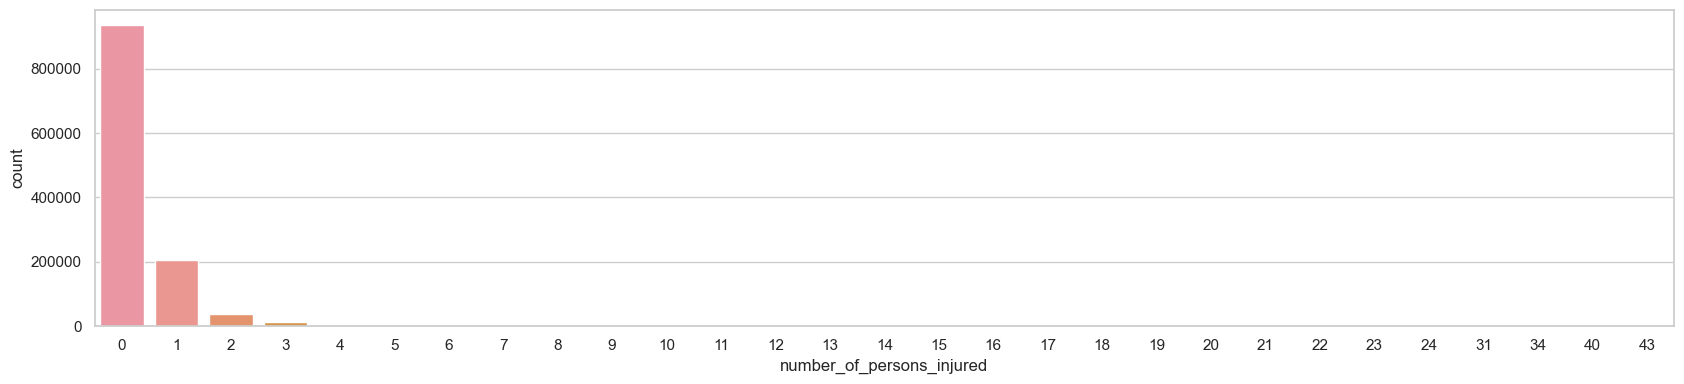

NUMBER_OF_PEDESTRIANS_INJURED
count of unique: 13
8           1
15          1
19          1
13          1
9           2
7           3
6           7
5          11
4          35
3         219
2        2037
1       61332
0     1139334
Name: number_of_pedestrians_injured, dtype: int64


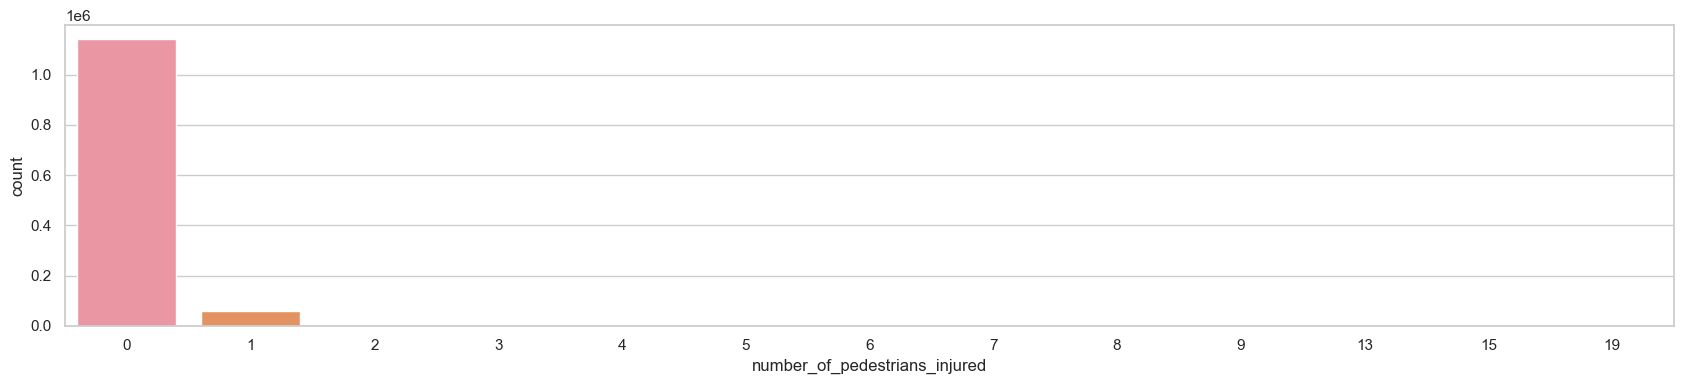

NUMBER_OF_CYCLIST_INJURED
count of unique: 4
3          9
2        312
1      30359
0    1172304
Name: number_of_cyclist_injured, dtype: int64


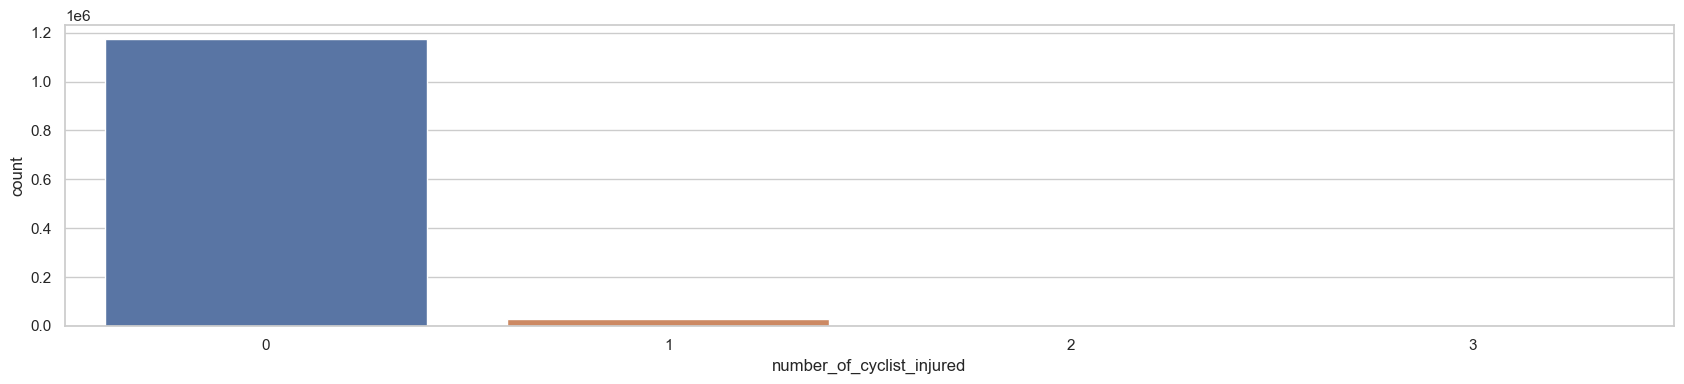

NUMBER_OF_MOTORIST_INJURED
count of unique: 28
21          1
23          1
34          1
40          1
31          1
43          1
19          1
24          2
20          2
17          3
18          4
15          4
16          8
14          8
13         15
12         17
11         26
10         47
9          72
8         134
7         310
6         759
5        1828
4        4627
3       12366
2       35527
1      114798
0     1032420
Name: number_of_motorist_injured, dtype: int64


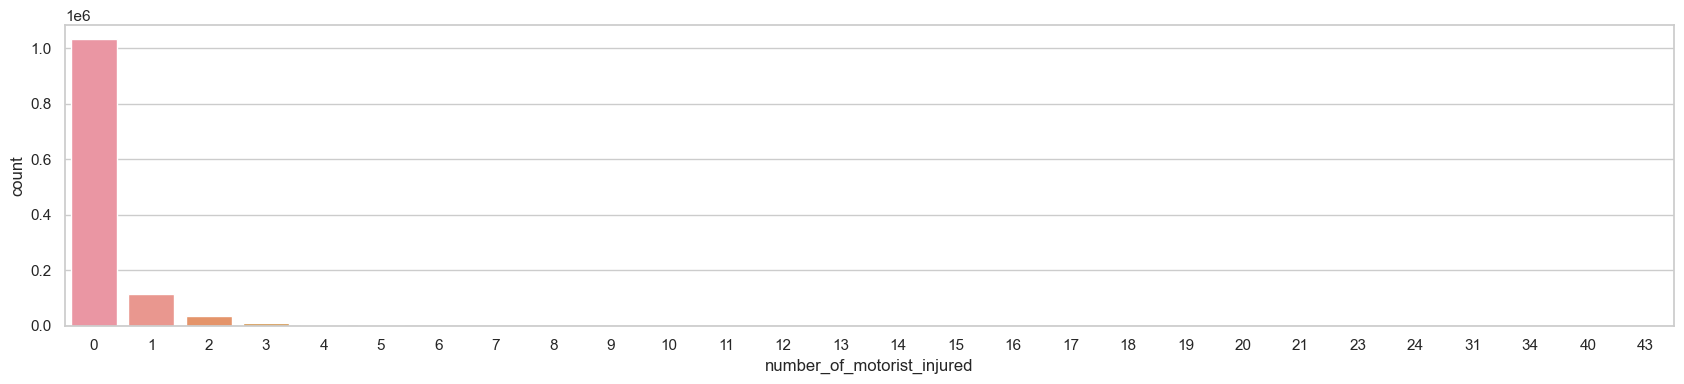

CONTRIBUTING_FACTOR_VEHICLE_1
count of unique: 16
Distracted Driving                                 119
Other                                              224
Issues with Traffic Control and Lane Marking      1038
Interactions with Pedestrians and Cyclists        6359
Distractions from Electronic Devices              9491
Aggressive Driving and Passenger Distraction     10233
Reactions to Other Vehicles                      12293
Impairment (Alcohol, Drugs, Medication)          22871
Driver Characteristics and Experience            24040
Visibility and Road Conditions                   25904
Unsafe Lane Changes and Backing                  44723
Vehicle-related Incidents                        45646
Vehicle Equipment Failure                        92380
Unsafe Driving Maneuvers                        189465
Driver Fatigue and Inattention                  301413
Uncertain or Unspecified Factors                416785
Name: contributing_factor_vehicle_1, dtype: int64


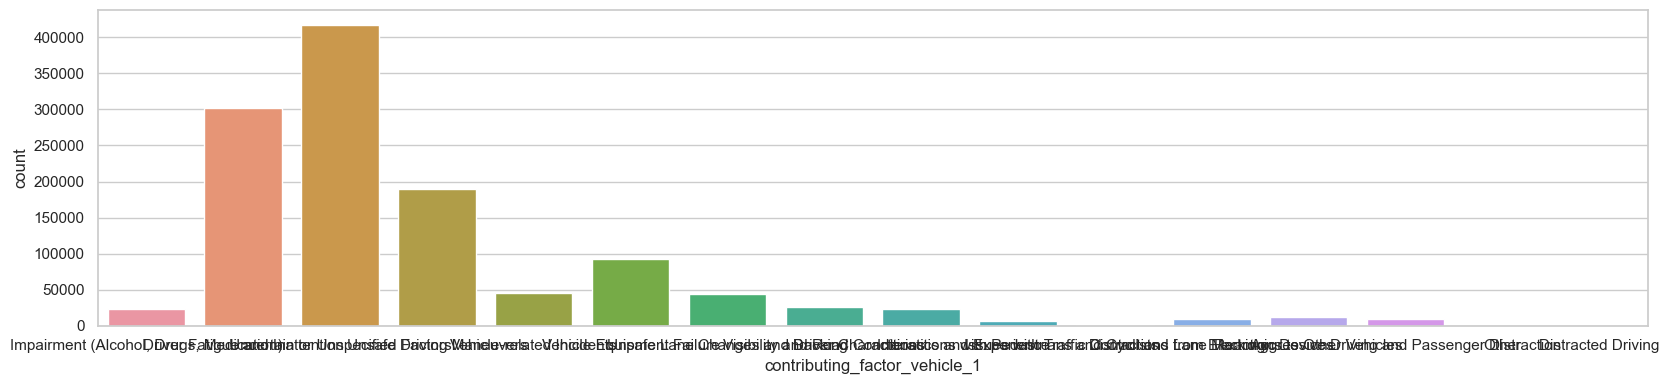

CONTRIBUTING_FACTOR_VEHICLE_2
count of unique: 16
Distracted Driving                                   11
Other                                                43
Issues with Traffic Control and Lane Marking        590
Interactions with Pedestrians and Cyclists         1333
Aggressive Driving and Passenger Distraction       1833
Distractions from Electronic Devices               1986
Reactions to Other Vehicles                        2213
Impairment (Alcohol, Drugs, Medication)            2898
Unsafe Lane Changes and Backing                    4645
Visibility and Road Conditions                     5067
Driver Characteristics and Experience              5209
Vehicle Equipment Failure                         15611
Vehicle-related Incidents                         20188
Unsafe Driving Maneuvers                          31799
Driver Fatigue and Inattention                    67774
Uncertain or Unspecified Factors                1041784
Name: contributing_factor_vehicle_2, dtype: int64


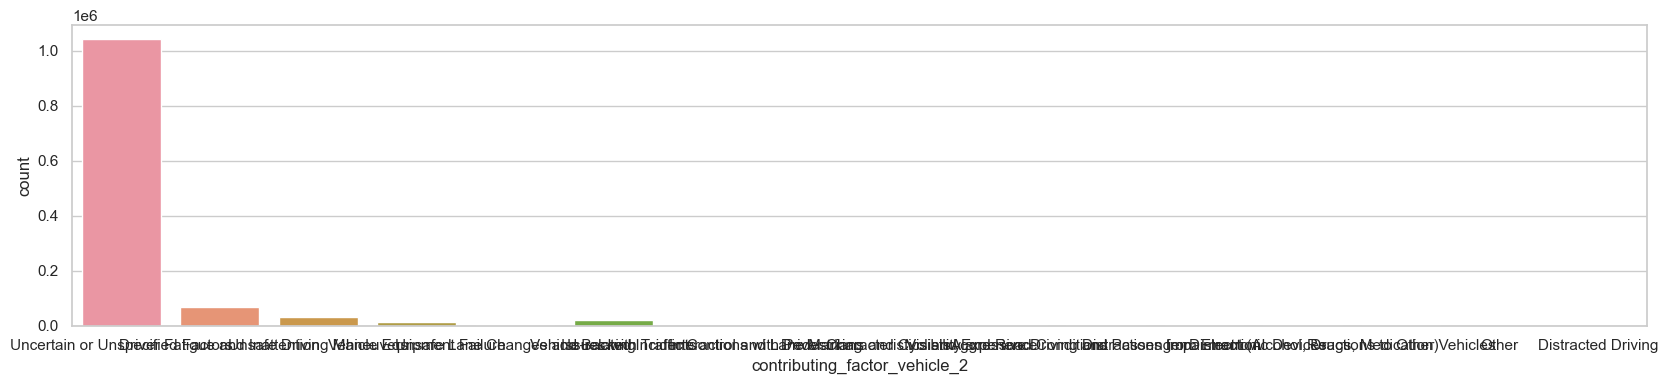

CONTRIBUTING_FACTOR_VEHICLE_3
count of unique: 15
Other                                                 1
Issues with Traffic Control and Lane Marking         13
Interactions with Pedestrians and Cyclists           19
Aggressive Driving and Passenger Distraction         31
Unsafe Lane Changes and Backing                      52
Impairment (Alcohol, Drugs, Medication)              71
Driver Characteristics and Experience               123
Distractions from Electronic Devices                125
Reactions to Other Vehicles                         125
Unsafe Driving Maneuvers                            287
Visibility and Road Conditions                      324
Vehicle Equipment Failure                          1252
Vehicle-related Incidents                          1595
Driver Fatigue and Inattention                     1736
Uncertain or Unspecified Factors                1197230
Name: contributing_factor_vehicle_3, dtype: int64


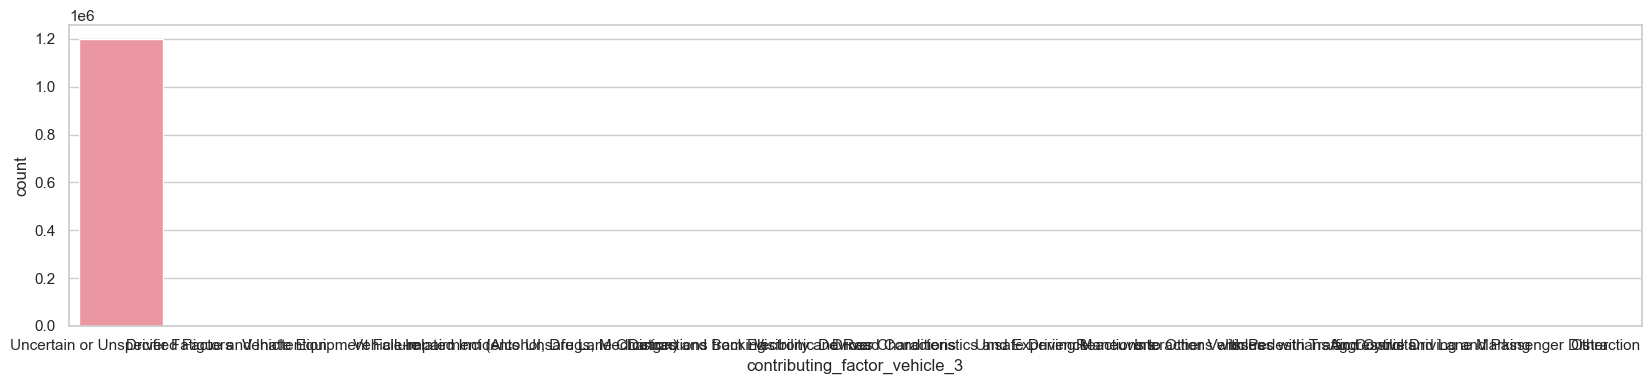

CONTRIBUTING_FACTOR_VEHICLE_4
count of unique: 13
Issues with Traffic Control and Lane Marking          2
Aggressive Driving and Passenger Distraction          6
Unsafe Lane Changes and Backing                       7
Impairment (Alcohol, Drugs, Medication)              17
Distractions from Electronic Devices                 20
Driver Characteristics and Experience                22
Unsafe Driving Maneuvers                             31
Reactions to Other Vehicles                          31
Visibility and Road Conditions                       82
Vehicle Equipment Failure                           236
Driver Fatigue and Inattention                      295
Vehicle-related Incidents                           343
Uncertain or Unspecified Factors                1201892
Name: contributing_factor_vehicle_4, dtype: int64


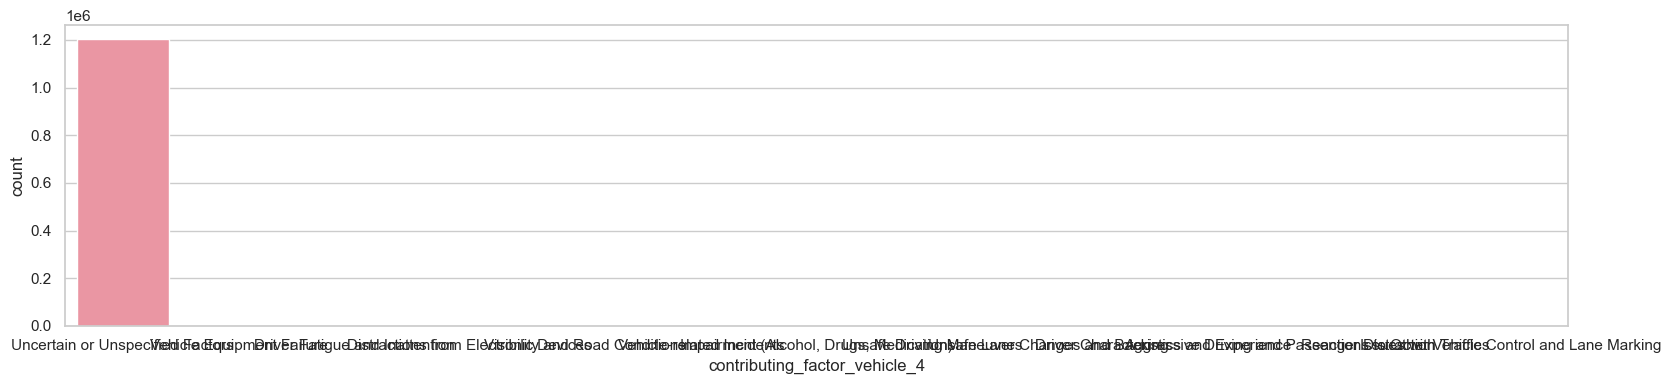

CONTRIBUTING_FACTOR_VEHICLE_5
count of unique: 12
Aggressive Driving and Passenger Distraction          1
Issues with Traffic Control and Lane Marking          1
Distractions from Electronic Devices                  5
Unsafe Driving Maneuvers                              7
Reactions to Other Vehicles                           8
Driver Characteristics and Experience                 8
Impairment (Alcohol, Drugs, Medication)              12
Visibility and Road Conditions                       33
Vehicle Equipment Failure                            59
Driver Fatigue and Inattention                       75
Vehicle-related Incidents                           106
Uncertain or Unspecified Factors                1202669
Name: contributing_factor_vehicle_5, dtype: int64


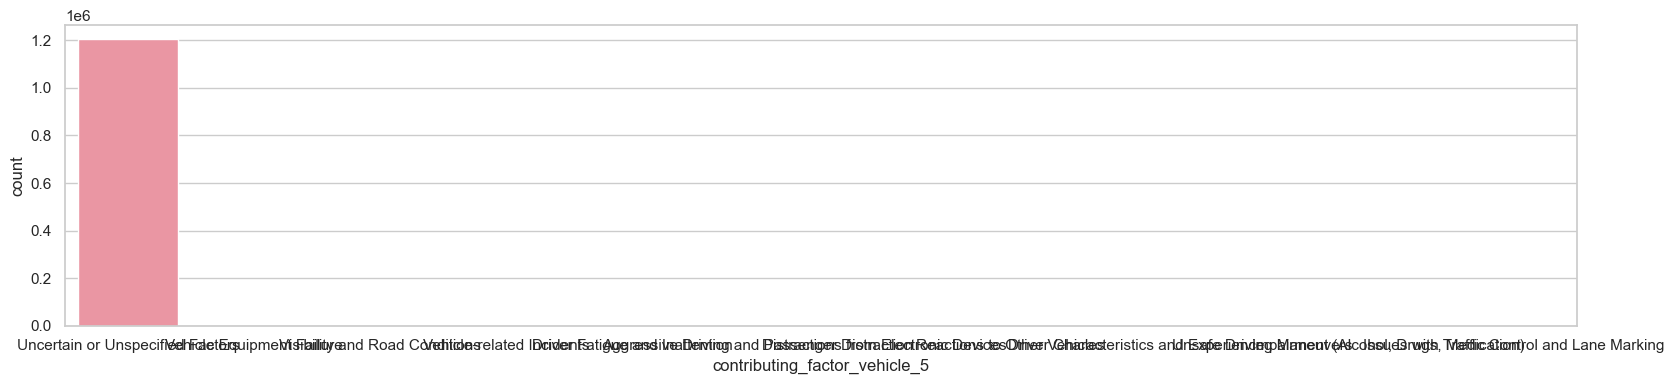

VEHICLE_TYPE_CODE_3
count of unique: 46
FORKLIFT                        1
USPS                            1
OPEN_BODY                       1
SMALL_COM_VEH                   1
BEVERAGE_TRUCK                  2
MULTI_WHEELED_VEHICLE           2
MOTORIZED_HOME                  2
ARMORED_TRUCK                   2
REFRIGERATED_VAN                3
STAKE_OR_RACK                   4
PEDICAB                         4
BULK_AGRICULTURE                5
FLAT_RACK                       6
LIMO                            6
LIFT_BOOM                       7
TRUCK                           7
SCOOTER                         8
CHASSIS_CAB                    10
TANKER                         13
CONCRETE_MIXER                 13
TRAILER                        15
FIRE_TRUCK                     16
CARRY_ALL                      25
E_SCOOTER                      25
TRACTOR_TRUCK_GASOLINE         29
GARBAGE_OR_REFUSE              33
E_BIKE                         39
TOW_TRUCK                      50
AMBULANC

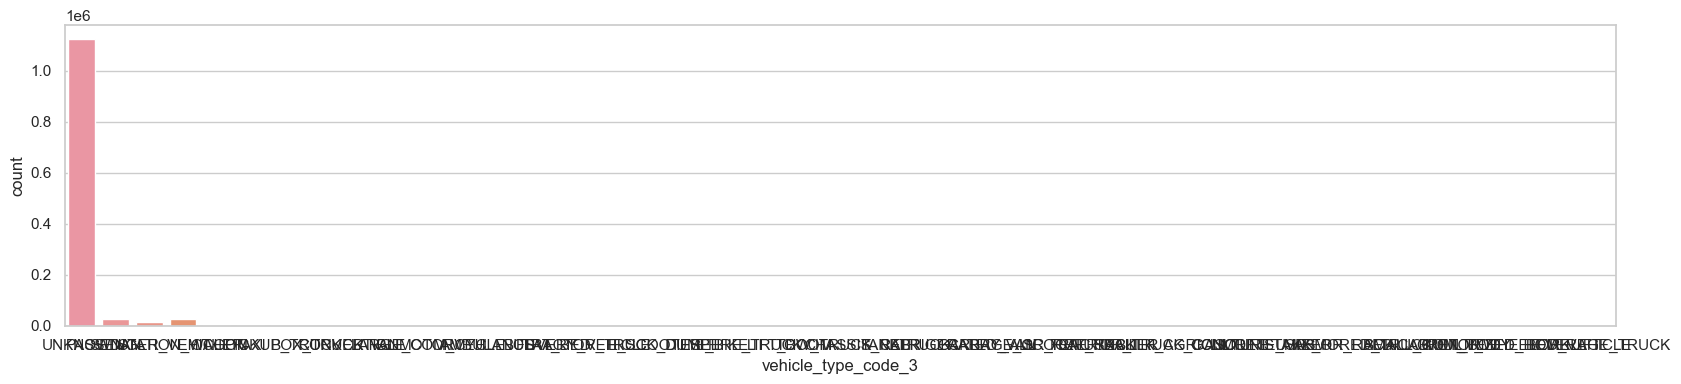

VEHICLE_TYPE_CODE_4
count of unique: 36
BULK_AGRICULTURE                1
MULTI_WHEELED_VEHICLE           1
OPEN_BODY                       1
TRACTOR_TRUCK_GASOLINE          1
PEDICAB                         1
REFRIGERATED_VAN                2
FIRE_TRUCK                      2
BEVERAGE_TRUCK                  2
CHASSIS_CAB                     2
TRAILER                         2
SCOOTER                         3
TANKER                          4
TOW_TRUCK                       4
AMBULANCE                       4
E_BIKE                          5
LIMO                            5
E_SCOOTER                       5
FLAT_BED                        6
CARRY_ALL                       7
GARBAGE_OR_REFUSE               9
DUMP                           16
TRACTOR_TRUCK_DIESEL           29
CONVERTIBLE                    30
LIVERY_VEHICLE                 38
LARGE_COM_VEH                  41
MOTORCYCLE                     45
BOX_TRUCK                      72
BUS                            78
VAN     

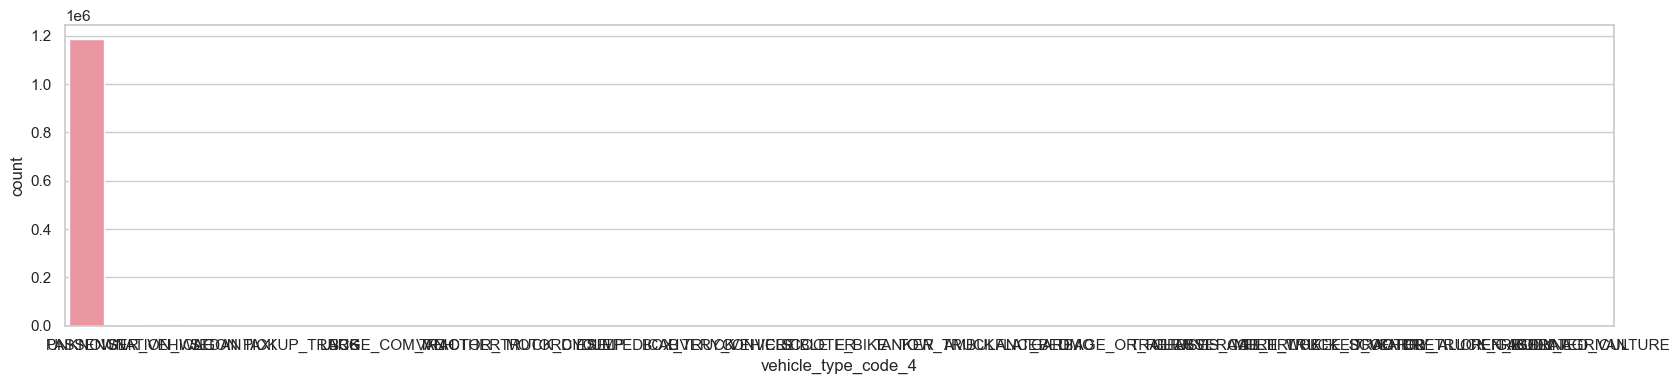

VEHICLE_TYPE_CODE_5
count of unique: 28
TOW_TRUCK                       1
TRAILER                         1
TRUCK                           1
ARMORED_TRUCK                   1
TANKER                          1
CHASSIS_CAB                     1
SCOOTER                         2
CARRY_ALL                       2
E_SCOOTER                       3
TRACTOR_TRUCK_GASOLINE          3
E_BIKE                          4
AMBULANCE                       4
DUMP                            5
TRACTOR_TRUCK_DIESEL            6
LIVERY_VEHICLE                  7
CONVERTIBLE                    11
LARGE_COM_VEH                  12
BOX_TRUCK                      15
MOTORCYCLE                     15
BUS                            20
VAN                            46
OTHER                          69
TAXI                           80
PICKUP_TRUCK                  119
PASSENGER_VEHICLE             903
SEDAN                        1791
STATION_WAGON                1869
UNKNOWN                   1197992
Name: ve

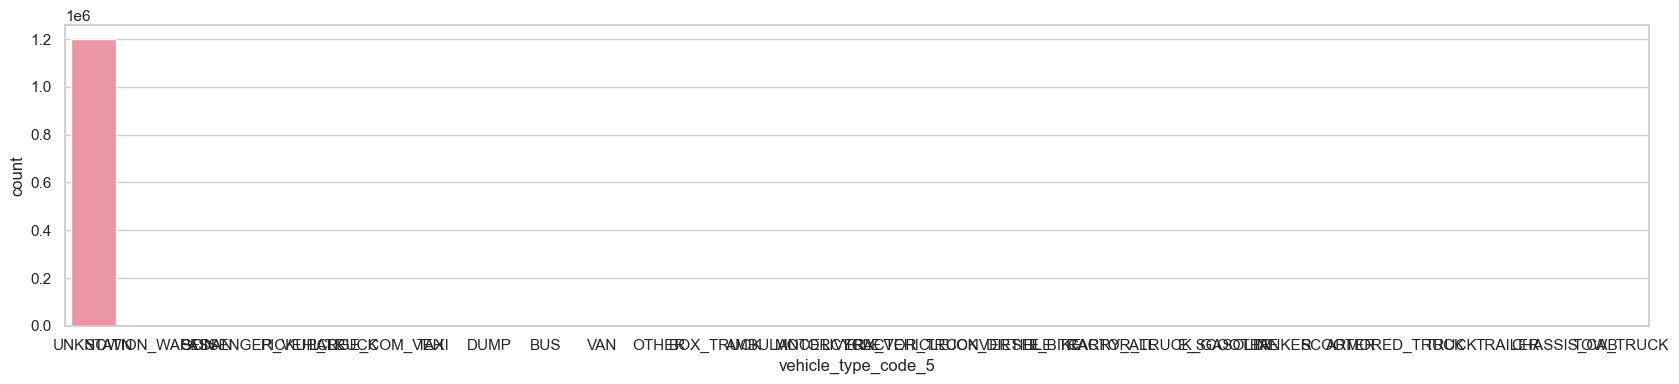

In [20]:
plot_categorical_and_continuous_vars()

**Continuous variables**

Here I will use hitograms, and kernel density plot to my continious variables with added discriptive statistics to help me identify

- The shape of my distributon, peaks and modes, outliets and imbalance in my data.

In [33]:
# find only columns with low count of categories
train_continious = train.nunique()[train.nunique() > 50].index
train_continious = train_continious[train_continious != "crash_date"]
train_continious = train_continious[train_continious != "crash_time"]
train_continious

Index(['zip_code', 'latitude', 'longitude', 'on_street_name',
       'cross_street_name', 'off_street_name'],
      dtype='object')

ZIP_CODE
count of unique: 233


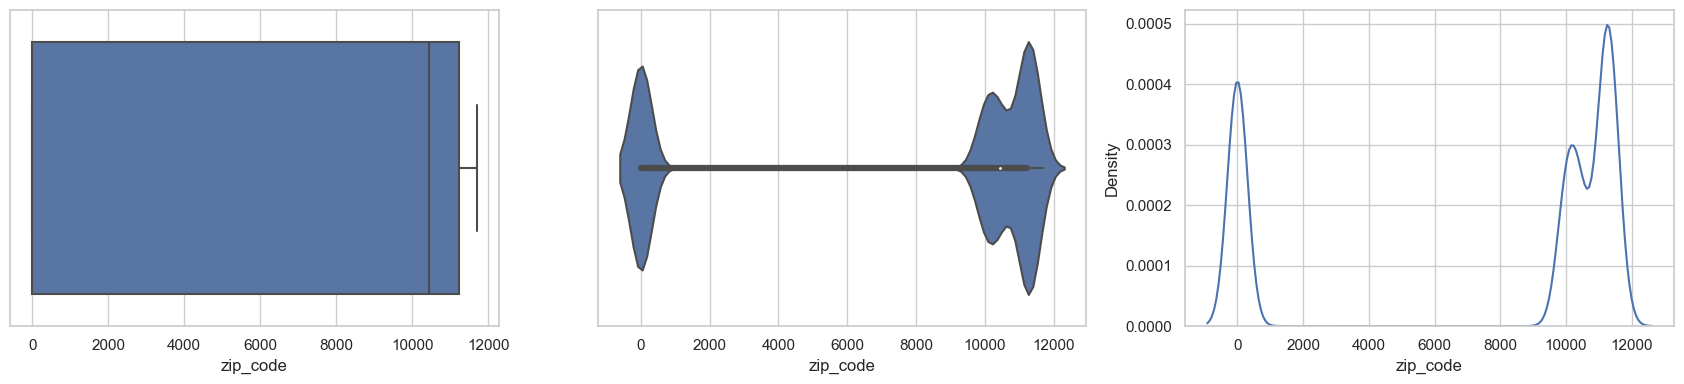

LATITUDE
count of unique: 111523


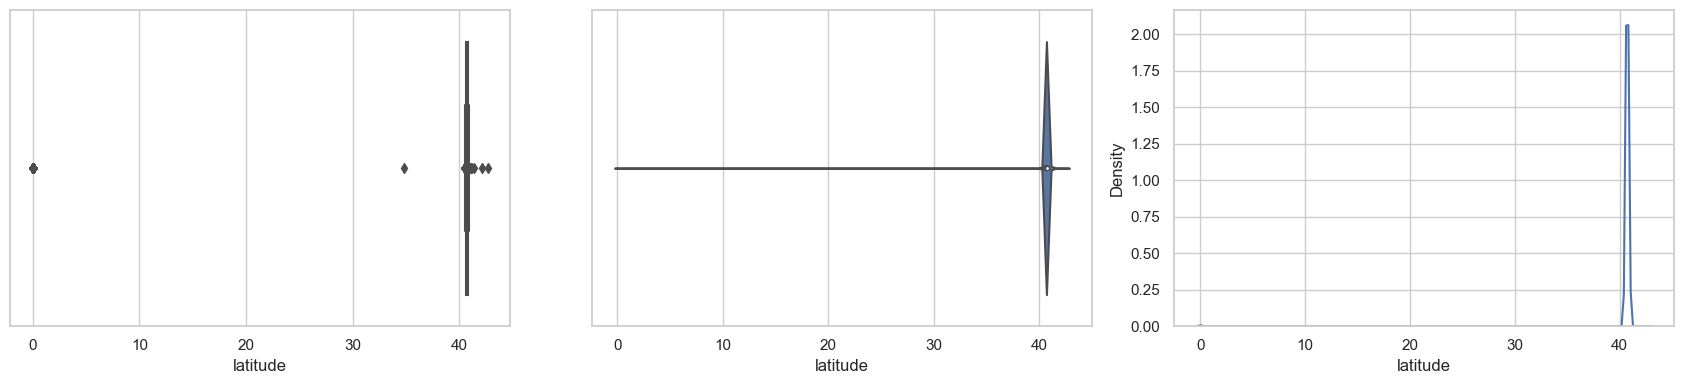

LONGITUDE
count of unique: 87266


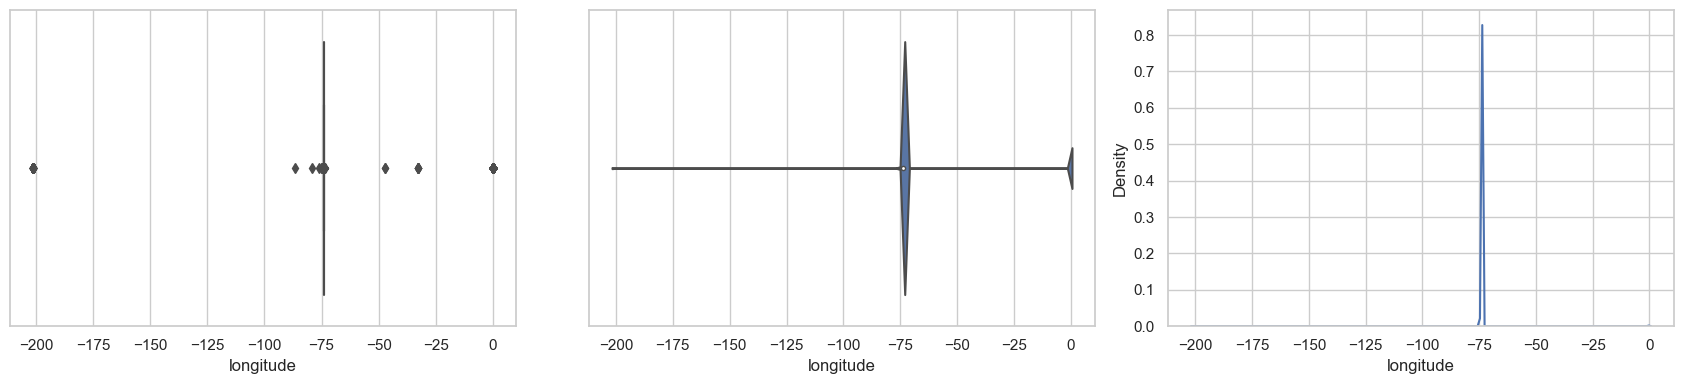

ON_STREET_NAME
count of unique: 14981


TypeError: Horizontal orientation requires numeric `x` variable.

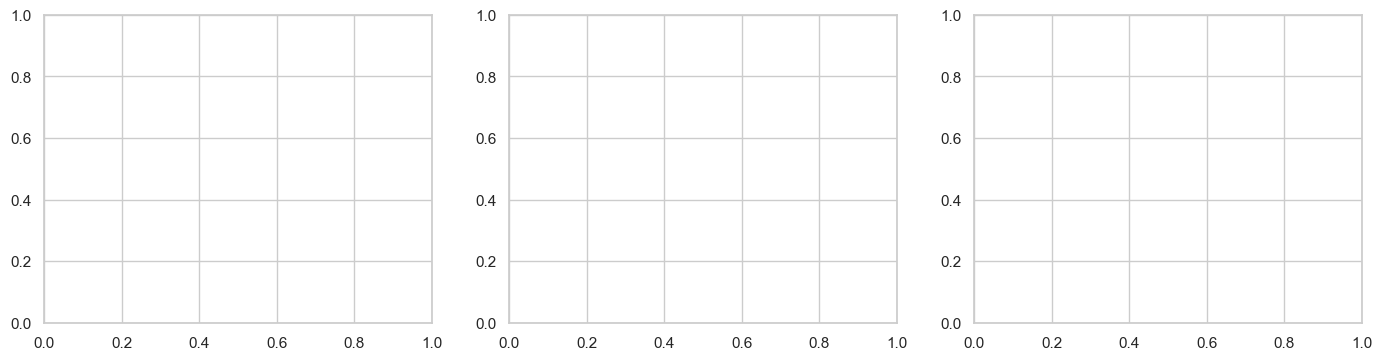

In [34]:
# plot all the low category columns to see the distributions
for col in train_continious:
    print(col.upper())
    print("count of unique:",train[col].nunique())
    # plot
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
    sns.boxplot(data= train, x=col, ax=ax[0])
    sns.violinplot(data= train, x=col, ax=ax[1])
    sns.kdeplot(train, x=col, ax=ax[2])
    plt.tight_layout()
    
    # save visual to file path
    explore_.save_visuals(fig=fig, viz_name=col, folder_name= 1)

    plt.show()

In [28]:
train_continious

Index(['crash_date', 'crash_time', 'zip_code', 'latitude', 'longitude',
       'on_street_name', 'cross_street_name', 'off_street_name'],
      dtype='object')

## Bivariate Stats

In [ ]:
# create visuals for each continuous varable
for ele in continuous_col:
    print(ele.upper())
    print(train[ele].describe())
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    # first plot
    sns.histplot(train[ele], ax=ax[0])
    
    # second plot
    sns.kdeplot(train[ele], ax=ax[1])
    
    plt.tight_layout()
    explore_.save_visuals(fig, viz_name= ele, 1)
    plt.show()

# Multivariate Stats